In [1]:
# Set GPU runtime first: Runtime > Change Runtime Type > GPU

# Check GPU
!nvidia-smi

Wed Jul  9 14:54:53 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Install specific compatible versions
!pip install gymnasium==0.29.1
!pip install ale-py==0.9.0
!pip install stable-baselines3==2.3.2
!pip install autorom[accept-rom-license]==0.6.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 11.0 MB/s eta 0:00:00
  Attempting uninstall: gymnasium
    Found existing installation: gymnasium 1.2.0
    Uninstalling gymnasium-1.2.0:
      Successfully uninstalled gymnasium-1.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.1 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 4.0 MB/s eta 0:00:00
  Attempting uninstall: ale-py
    Found existing installation: ale-py 0.11.1
    Uninstalling ale-py-0.11.1:
      Successfully uninstalled ale-py-0.11.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires ale-py>=0.10.1, but you have ale-py 0.9.0 which i

In [3]:
# Install ROMs with proper acceptance
!AutoROM --accept-license --install-dir /usr/local/lib/python3.11/dist-packages/ale_py/roms

AutoROM will download the Atari 2600 ROMs.
They will be installed to:
	/usr/local/lib/python3.11/dist-packages/ale_py/roms

Existing ROMs will be overwritten.


In [18]:
import os
import random
import time
from dataclasses import dataclass
from typing import Optional

import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from stable_baselines3.common.atari_wrappers import (
    ClipRewardEnv,
    EpisodicLifeEnv,
    FireResetEnv,
    MaxAndSkipEnv,
    NoopResetEnv,
)
from stable_baselines3.common.buffers import ReplayBuffer
from torch.utils.tensorboard import SummaryWriter
import ale_py # Import ale_py

# Register ALE environments
gym.register_envs(ale_py)

class CustomQNetwork(nn.Module):
    """Custom CNN for Asteroids - you can modify this architecture!"""

    def __init__(self, env, hidden_size=512):
        super().__init__()
        self.env = env

        # CNN Feature Extractor - CUSTOMIZE THIS!
        # Example: Deeper network for more complex features
        self.network = nn.Sequential(
            # More filters to detect asteroid shapes
            nn.Conv2d(4, 64, 8, stride=4),  # 32 → 64 filters
            nn.ReLU(),

            # Additional layer for rotation detection
            nn.Conv2d(64, 128, 4, stride=2),  # 64 → 128 filters
            nn.ReLU(),

            # Smaller kernel for fine details
            nn.Conv2d(128, 128, 3, stride=1),
            nn.ReLU(),

            # Extra layer for asteroid physics
            nn.Conv2d(128, 64, 3, stride=1),  # New layer!
            nn.ReLU(),

            nn.Flatten(),
        )

        """
        # CNN Feature Extractor - CUSTOMIZE THIS!
        self.network = nn.Sequential(

            # First conv layer: detect basic shapes
            nn.Conv2d(4, 32, 8, stride=4),
            nn.ReLU(),

            # Second conv layer: detect movement patterns
            nn.Conv2d(32, 64, 4, stride=2),
            nn.ReLU(),

            # Third conv layer: complex spatial relationships
            nn.Conv2d(64, 64, 3, stride=1),
            nn.ReLU(),

            nn.Flatten(),
        )
        """

        # Calculate conv output size
        with torch.no_grad():
            sample_input = torch.zeros(1, 4, 84, 84)
            conv_output_size = self.network(sample_input).shape[1]

        # Value head - CUSTOMIZE THIS!
        self.value_head = nn.Sequential(
            nn.Linear(conv_output_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, env.single_action_space.n) # FIX: Changed hidden_size // 2 to hidden_size
        )

    def forward(self, x):
        features = self.network(x / 255.0)  # Normalize pixels
        return self.value_head(features)


def make_env(env_id, seed, idx, capture_video, run_name):
    """Create Asteroids environment with proper wrappers"""
    def thunk():
        if capture_video and idx == 0:
            env = gym.make(env_id, render_mode="rgb_array")
            env = gym.wrappers.RecordVideo(env, f"videos/{run_name}")
        else:
            env = gym.make(env_id)

        print(f"✅ Successfully created environment: {env_id}")

        env = gym.wrappers.RecordEpisodeStatistics(env)
        env = NoopResetEnv(env, noop_max=30)
        env = MaxAndSkipEnv(env, skip=4)
        env = EpisodicLifeEnv(env)

        if "FIRE" in env.unwrapped.get_action_meanings():
            env = FireResetEnv(env)

        env = ClipRewardEnv(env)
        env = gym.wrappers.ResizeObservation(env, (84, 84))
        env = gym.wrappers.GrayScaleObservation(env)
        env = gym.wrappers.FrameStack(env, 4)

        env.action_space.seed(seed)
        return env
    return thunk


def linear_schedule(start_e: float, end_e: float, duration: int, t: int):
    """Linear decay for exploration"""
    slope = (end_e - start_e) / duration
    return max(slope * t + start_e, end_e)


def train_asteroids_dqn():
    """Main training function"""
    args = Args()

    # Setup
    run_name = f"{args.env_id}__{args.exp_name}__{args.seed}__{int(time.time())}"
    writer = SummaryWriter(f"runs/{run_name}")

    # Seeding
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    torch.backends.cudnn.deterministic = args.torch_deterministic

    device = torch.device("cuda" if torch.cuda.is_available() and args.cuda else "cpu")

    # Environment
    envs = gym.vector.SyncVectorEnv([
        make_env(args.env_id, args.seed, 0, True, run_name)
    ])

    # Networks
    q_network = CustomQNetwork(envs, hidden_size=512).to(device)
    optimizer = optim.Adam(q_network.parameters(), lr=args.learning_rate)
    target_network = CustomQNetwork(envs, hidden_size=512).to(device)
    target_network.load_state_dict(q_network.state_dict())

    # Experience Replay
    rb = ReplayBuffer(
        args.buffer_size,
        envs.single_observation_space,
        envs.single_action_space,
        device,
        handle_timeout_termination=False,
    )

    # Training Loop
    obs, _ = envs.reset(seed=args.seed)
    episode_rewards = []
    episode_lengths = []

    for global_step in range(args.total_timesteps):
        # Exploration rate
        epsilon = linear_schedule(
            args.start_e, args.end_e,
            args.exploration_fraction * args.total_timesteps,
            global_step
        )

        # Action selection
        if random.random() < epsilon:
            actions = np.array([envs.single_action_space.sample()])
        else:
            q_values = q_network(torch.Tensor(obs).to(device))
            actions = torch.argmax(q_values, dim=1).cpu().numpy()

        # Environment step
        next_obs, rewards, terminations, truncations, infos = envs.step(actions)

        # Track metrics
        if "final_info" in infos:
            for info in infos["final_info"]:
                if info and "episode" in info:
                    episode_rewards.append(info["episode"]["r"])
                    episode_lengths.append(info["episode"]["l"])
                    writer.add_scalar("charts/episodic_return", info["episode"]["r"], global_step)
                    writer.add_scalar("charts/episodic_length", info["episode"]["l"], global_step)
                    print(f"Step {global_step}, Episode reward: {info['episode']['r']}")

        # Store experience
        real_next_obs = next_obs.copy()
        for idx, d in enumerate(terminations):
            if d:
                real_next_obs[idx] = infos["final_observation"][idx]

        rb.add(obs, real_next_obs, actions, rewards, terminations, infos)
        obs = next_obs

        # Training
        if global_step > args.learning_starts:
            if global_step % args.train_frequency == 0:
                data = rb.sample(args.batch_size)

                with torch.no_grad():
                    target_max, _ = target_network(data.next_observations).max(dim=1)
                    td_target = data.rewards.flatten() + args.gamma * target_max * (1 - data.dones.flatten())

                old_val = q_network(data.observations).gather(1, data.actions).squeeze()
                loss = F.mse_loss(td_target, old_val)

                if global_step % 1000 == 0:
                    writer.add_scalar("losses/td_loss", loss, global_step)
                    writer.add_scalar("losses/q_values", old_val.mean().item(), global_step)
                    writer.add_scalar("charts/SPS", int(global_step / (time.time() - start_time)), global_step)

                # Optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # Update target network
        if global_step % args.target_network_frequency == 0:
            target_network.load_state_dict(q_network.state_dict())

    # Save model
    model_path = f"models/{run_name}.pt"
    os.makedirs("models", exist_ok=True)
    torch.save(q_network.state_dict(), model_path)

    envs.close()
    writer.close()

    return q_network, episode_rewards, model_path


def evaluate_model(model_path, num_episodes=10):
    """Evaluate trained model on Asteroids"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Create environment
    env = gym.vector.SyncVectorEnv([make_env("AsteroidsNoFrameskip-v4", 42, 0, False, "eval")])
    q_network = CustomQNetwork(env).to(device)
    q_network.load_state_dict(torch.load(model_path))
    q_network.eval()

    print(f"✅ Evaluating on: AsteroidsNoFrameskip-v4")

    # Evaluate
    obs, _ = env.reset()
    episode_rewards = []
    episode_lengths = []
    current_reward = 0
    current_length = 0

    for step in range(50000):  # Max steps for evaluation
        with torch.no_grad():
            q_values = q_network(torch.Tensor(obs).to(device))
            actions = torch.argmax(q_values, dim=1).cpu().numpy()

        obs, rewards, terminations, truncations, infos = env.step(actions)
        current_reward += rewards[0]
        current_length += 1

        if terminations[0] or truncations[0]:
            episode_rewards.append(current_reward)
            episode_lengths.append(current_length)
            print(f"Episode {len(episode_rewards)}: {current_reward} points, {current_length} steps")

            current_reward = 0
            current_length = 0
            obs, _ = env.reset()

            if len(episode_rewards) >= num_episodes:
                break

    env.close()

    # Results
    avg_reward = np.mean(episode_rewards)
    avg_length = np.mean(episode_lengths)

    print(f"\n📊 Evaluation Results:")
    print(f"Average Score: {avg_reward:.1f}")
    print(f"Average Length: {avg_length:.0f}")
    print(f"Best Score: {max(episode_rewards)}")
    print(f"Episodes: {len(episode_rewards)}")

    return episode_rewards, episode_lengths

"""
if __name__ == "__main__":
    start_time = time.time()
    print("🚀 Starting Custom Asteroids DQN Training...")

    # Train the model
    model, rewards, model_path = train_asteroids_dqn()

    print(f"✅ Training completed! Model saved to: {model_path}")
    print(f"Training time: {(time.time() - start_time)/60:.1f} minutes")

    # Evaluate the model
    print("\n🎯 Evaluating trained model...")
    eval_rewards, eval_lengths = evaluate_model(model_path)
"""

'\nif __name__ == "__main__":\n    start_time = time.time()\n    print("🚀 Starting Custom Asteroids DQN Training...")\n\n    # Train the model\n    model, rewards, model_path = train_asteroids_dqn()\n\n    print(f"✅ Training completed! Model saved to: {model_path}")\n    print(f"Training time: {(time.time() - start_time)/60:.1f} minutes")\n\n    # Evaluate the model\n    print("\n🎯 Evaluating trained model...")\n    eval_rewards, eval_lengths = evaluate_model(model_path)\n'

## DQN Code for Asteroids

In [19]:
@dataclass
class Args:
    """Fixed Args class with all required parameters"""
    exp_name: str = "increase_network_size_dqn"
    seed: int = 1
    torch_deterministic: bool = True
    cuda: bool = True

    env_id: str = "AsteroidsNoFrameskip-v4"

    # MAXIMUM PERFORMANCE SETTINGS
    total_timesteps: int = 2500000
    learning_rate: float = 5e-5
    buffer_size: int = 400000
    batch_size: int = 64
    target_network_frequency: int = 2000
    exploration_fraction: float = 0.20
    train_frequency: int = 2
    gamma: float = 0.995
    gradient_steps: int = 1
    learning_starts: int = 400000

    # FIXED: Include both parameter names for compatibility
    start_e: float = 1.0
    end_e: float = 0.005                    # 🔧 FIX: This was missing
    exploration_final_eps: float = 0.005    # Same value, different name

print("✅ Args class fixed with both parameter names")
print("   start_e: 1.0")
print("   end_e: 0.005")
print("   exploration_final_eps: 0.005")


✅ Args class fixed with both parameter names
   start_e: 1.0
   end_e: 0.005
   exploration_final_eps: 0.005


In [ ]:
print("🚀 STARTING TRAINING WITH YOUR HIGH-MEMORY SETTINGS")
print("=" * 60)

# Display your settings
args_test = Args()
print("📋 Training Configuration:")
print(f"   Buffer Size: {args_test.buffer_size:,} experiences")
print(f"   Learning Starts: {args_test.learning_starts:,} steps")
print(f"   Total Steps: {args_test.total_timesteps:,}")
print(f"   Learning Rate: {args_test.learning_rate}")
print(f"   Batch Size: {args_test.batch_size}")
print(f"   Expected Time: ~4-5 hours")
print(f"   Target Performance: 300-500+ points")

print("\n🎯 Starting training now...")
start_time = time.time()

# Just run your training function
model, episode_rewards, model_path = train_asteroids_dqn()

# When done, show results
training_time = (time.time() - start_time) / 60
print(f"\n✅ TRAINING COMPLETED!")
print(f"⏱️  Training Time: {training_time:.1f} minutes")
print(f"📁 Model Saved: {model_path}")

# Quick evaluation
print("\n🎯 Quick Performance Check:")
eval_rewards, eval_lengths = evaluate_model(model_path, num_episodes=10)
avg_score = np.mean(eval_rewards)
print(f"Average Score: {avg_score:.1f} points")
print(f"Improvement vs Original (152.5): {avg_score - 152.5:+.1f} points")

if avg_score > 300:
    print("🔥 EXCELLENT! High-memory training worked!")
elif avg_score > 200:
    print("✅ GOOD! Significant improvement achieved!")
else:
    print("📈 Some improvement, may need more analysis")

🚀 STARTING TRAINING WITH YOUR HIGH-MEMORY SETTINGS
📋 Training Configuration:
   Buffer Size: 400,000 experiences
   Learning Starts: 400,000 steps
   Total Steps: 2,500,000
   Learning Rate: 5e-05
   Batch Size: 64
   Expected Time: ~4-5 hours
   Target Performance: 300-500+ points

🎯 Starting training now...
✅ Successfully created environment: AsteroidsNoFrameskip-v4


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Moviepy - Building video /content/videos/AsteroidsNoFrameskip-v4__increase_network_size_dqn__1__1752073519/rl-video-episode-0.mp4.
Moviepy - Writing video /content/videos/AsteroidsNoFrameskip-v4__increase_network_size_dqn__1__1752073519/rl-video-episode-0.mp4



/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Moviepy - Done !
Moviepy - video ready /content/videos/AsteroidsNoFrameskip-v4__increase_network_size_dqn__1__1752073519/rl-video-episode-0.mp4
Step 538, Episode reward: [480.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Moviepy - Building video /content/videos/AsteroidsNoFrameskip-v4__increase_network_size_dqn__1__1752073519/rl-video-episode-1.mp4.
Moviepy - Writing video /content/videos/AsteroidsNoFrameskip-v4__increase_network_size_dqn__1__1752073519/rl-video-episode-1.mp4



/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Moviepy - Done !
Moviepy - video ready /content/videos/AsteroidsNoFrameskip-v4__increase_network_size_dqn__1__1752073519/rl-video-episode-1.mp4
Step 1166, Episode reward: [310.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 2493, Episode reward: [1300.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 3016, Episode reward: [430.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 3889, Episode reward: [680.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 4624, Episode reward: [930.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 6719, Episode reward: [1390.]
Step 7236, Episode reward: [580.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Moviepy - Building video /content/videos/AsteroidsNoFrameskip-v4__increase_network_size_dqn__1__1752073519/rl-video-episode-8.mp4.
Moviepy - Writing video /content/videos/AsteroidsNoFrameskip-v4__increase_network_size_dqn__1__1752073519/rl-video-episode-8.mp4



/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Moviepy - Done !
Moviepy - video ready /content/videos/AsteroidsNoFrameskip-v4__increase_network_size_dqn__1__1752073519/rl-video-episode-8.mp4
Step 8457, Episode reward: [1030.]
Step 9037, Episode reward: [380.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 9869, Episode reward: [830.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 10711, Episode reward: [530.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 11387, Episode reward: [480.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 13584, Episode reward: [1300.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 14177, Episode reward: [780.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 15230, Episode reward: [980.]
Step 15883, Episode reward: [780.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 16364, Episode reward: [630.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 17348, Episode reward: [1300.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 20402, Episode reward: [1300.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 20665, Episode reward: [160.]
Step 21333, Episode reward: [880.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 21614, Episode reward: [180.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 21893, Episode reward: [330.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 22613, Episode reward: [1080.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 23853, Episode reward: [1340.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 25681, Episode reward: [1340.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Moviepy - Building video /content/videos/AsteroidsNoFrameskip-v4__increase_network_size_dqn__1__1752073519/rl-video-episode-27.mp4.
Moviepy - Writing video /content/videos/AsteroidsNoFrameskip-v4__increase_network_size_dqn__1__1752073519/rl-video-episode-27.mp4



/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Moviepy - Done !
Moviepy - video ready /content/videos/AsteroidsNoFrameskip-v4__increase_network_size_dqn__1__1752073519/rl-video-episode-27.mp4
Step 26636, Episode reward: [680.]
Step 27262, Episode reward: [930.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 27891, Episode reward: [480.]
Step 28648, Episode reward: [980.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 29216, Episode reward: [530.]
Step 29475, Episode reward: [210.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 30932, Episode reward: [1180.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 31517, Episode reward: [680.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 32634, Episode reward: [1630.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 34060, Episode reward: [1180.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 35648, Episode reward: [1560.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 36427, Episode reward: [730.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 37512, Episode reward: [1130.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 38121, Episode reward: [310.]
Step 38671, Episode reward: [880.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 38892, Episode reward: [340.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 40199, Episode reward: [1080.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 41045, Episode reward: [580.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 41855, Episode reward: [880.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 42664, Episode reward: [780.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 43487, Episode reward: [1080.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 44245, Episode reward: [930.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 44778, Episode reward: [630.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 45787, Episode reward: [1030.]
Step 46147, Episode reward: [460.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 47694, Episode reward: [2130.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 48331, Episode reward: [530.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 49345, Episode reward: [880.]
Step 49867, Episode reward: [680.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 50878, Episode reward: [680.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 51426, Episode reward: [580.]
Step 51691, Episode reward: [130.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 53675, Episode reward: [1300.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 54515, Episode reward: [780.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 55088, Episode reward: [630.]
Step 56493, Episode reward: [1810.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 58142, Episode reward: [1390.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Moviepy - Building video /content/videos/AsteroidsNoFrameskip-v4__increase_network_size_dqn__1__1752073519/rl-video-episode-64.mp4.
Moviepy - Writing video /content/videos/AsteroidsNoFrameskip-v4__increase_network_size_dqn__1__1752073519/rl-video-episode-64.mp4



/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Moviepy - Done !
Moviepy - video ready /content/videos/AsteroidsNoFrameskip-v4__increase_network_size_dqn__1__1752073519/rl-video-episode-64.mp4
Step 58648, Episode reward: [830.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 59700, Episode reward: [1180.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 61272, Episode reward: [1300.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 62382, Episode reward: [1080.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 62645, Episode reward: [110.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 64397, Episode reward: [1530.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 66183, Episode reward: [1320.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 67078, Episode reward: [680.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 67584, Episode reward: [830.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 68760, Episode reward: [1300.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 70762, Episode reward: [1420.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 71340, Episode reward: [930.]
Step 72022, Episode reward: [830.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword argume

Step 74964, Episode reward: [1540.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 75620, Episode reward: [880.]
Step 75911, Episode reward: [230.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 76380, Episode reward: [530.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 76738, Episode reward: [280.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 78174, Episode reward: [1390.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 79896, Episode reward: [1320.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 83026, Episode reward: [1660.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 84252, Episode reward: [1360.]
Step 85445, Episode reward: [1370.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 85766, Episode reward: [260.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 86240, Episode reward: [530.]
Step 86563, Episode reward: [210.]
Step 87602, Episode reward: [1350.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 89789, Episode reward: [1350.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 90180, Episode reward: [360.]
Step 90817, Episode reward: [830.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 91483, Episode reward: [780.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 91881, Episode reward: [330.]
Step 92749, Episode reward: [680.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 93802, Episode reward: [1030.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 94339, Episode reward: [530.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 95306, Episode reward: [730.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 95629, Episode reward: [310.]
Step 96138, Episode reward: [530.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 98229, Episode reward: [1630.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 98903, Episode reward: [930.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 99373, Episode reward: [610.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 100758, Episode reward: [1180.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 102007, Episode reward: [1180.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 102331, Episode reward: [380.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 103830, Episode reward: [1390.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 104949, Episode reward: [1300.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 105469, Episode reward: [430.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 106333, Episode reward: [1080.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 107186, Episode reward: [1080.]
Step 107683, Episode reward: [830.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 108666, Episode reward: [1080.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 109101, Episode reward: [580.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 109382, Episode reward: [460.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 110135, Episode reward: [780.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 111263, Episode reward: [980.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 111790, Episode reward: [680.]
Step 112495, Episode reward: [730.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 112931, Episode reward: [330.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 114130, Episode reward: [980.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 114628, Episode reward: [730.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 115216, Episode reward: [530.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Moviepy - Building video /content/videos/AsteroidsNoFrameskip-v4__increase_network_size_dqn__1__1752073519/rl-video-episode-125.mp4.
Moviepy - Writing video /content/videos/AsteroidsNoFrameskip-v4__increase_network_size_dqn__1__1752073519/rl-video-episode-125.mp4



/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Moviepy - Done !
Moviepy - video ready /content/videos/AsteroidsNoFrameskip-v4__increase_network_size_dqn__1__1752073519/rl-video-episode-125.mp4
Step 115814, Episode reward: [880.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 116859, Episode reward: [1180.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 117423, Episode reward: [380.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 117950, Episode reward: [880.]
Step 118195, Episode reward: [230.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 119677, Episode reward: [1510.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 121791, Episode reward: [1320.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 122384, Episode reward: [610.]
Step 122889, Episode reward: [630.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 123481, Episode reward: [360.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 125167, Episode reward: [1300.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 126224, Episode reward: [1080.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 126518, Episode reward: [260.]
Step 127168, Episode reward: [830.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 129205, Episode reward: [1280.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 129776, Episode reward: [830.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 130620, Episode reward: [880.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 131211, Episode reward: [930.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 131539, Episode reward: [260.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 132661, Episode reward: [1080.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 133154, Episode reward: [680.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 134268, Episode reward: [1080.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 134974, Episode reward: [780.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 135525, Episode reward: [880.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 136553, Episode reward: [880.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 137707, Episode reward: [1320.]
Step 138291, Episode reward: [530.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 139757, Episode reward: [1180.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 141632, Episode reward: [1390.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 141990, Episode reward: [130.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 142436, Episode reward: [480.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 143049, Episode reward: [330.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 143539, Episode reward: [530.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 144443, Episode reward: [930.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 145187, Episode reward: [430.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 146574, Episode reward: [1400.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 147343, Episode reward: [1030.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 147799, Episode reward: [330.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 148416, Episode reward: [780.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 149575, Episode reward: [980.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 152166, Episode reward: [2030.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 152915, Episode reward: [1180.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 153551, Episode reward: [630.]
Step 153945, Episode reward: [680.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 155305, Episode reward: [1320.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 156207, Episode reward: [1080.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 156830, Episode reward: [780.]
Step 157813, Episode reward: [1280.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 158687, Episode reward: [630.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 160523, Episode reward: [1340.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 161624, Episode reward: [1080.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 163289, Episode reward: [1180.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 165306, Episode reward: [1300.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 166688, Episode reward: [1300.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 168238, Episode reward: [1420.]
Step 168732, Episode reward: [480.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 169950, Episode reward: [1300.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 171480, Episode reward: [1130.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 172692, Episode reward: [1390.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 173094, Episode reward: [480.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 173803, Episode reward: [780.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 175484, Episode reward: [1710.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 176636, Episode reward: [1180.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 177223, Episode reward: [610.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 177508, Episode reward: [260.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 180231, Episode reward: [1550.]
Step 180682, Episode reward: [930.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 182784, Episode reward: [1700.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 183628, Episode reward: [980.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 185240, Episode reward: [1810.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 186260, Episode reward: [1280.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 187926, Episode reward: [1320.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 188288, Episode reward: [430.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 190482, Episode reward: [1490.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 192793, Episode reward: [1320.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 193414, Episode reward: [880.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 193766, Episode reward: [260.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 194421, Episode reward: [730.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 194948, Episode reward: [330.]
Step 196190, Episode reward: [1280.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 196718, Episode reward: [630.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 198076, Episode reward: [1560.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 199043, Episode reward: [880.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 200395, Episode reward: [1300.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 201068, Episode reward: [330.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 202281, Episode reward: [1180.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 203075, Episode reward: [1300.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 204452, Episode reward: [1370.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 206866, Episode reward: [1680.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 207742, Episode reward: [480.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 208670, Episode reward: [1080.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Moviepy - Building video /content/videos/AsteroidsNoFrameskip-v4__increase_network_size_dqn__1__1752073519/rl-video-episode-216.mp4.
Moviepy - Writing video /content/videos/AsteroidsNoFrameskip-v4__increase_network_size_dqn__1__1752073519/rl-video-episode-216.mp4



/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Moviepy - Done !
Moviepy - video ready /content/videos/AsteroidsNoFrameskip-v4__increase_network_size_dqn__1__1752073519/rl-video-episode-216.mp4
Step 209149, Episode reward: [830.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 210127, Episode reward: [1080.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 211138, Episode reward: [730.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 212475, Episode reward: [1130.]
Step 213026, Episode reward: [680.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 213301, Episode reward: [280.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 213793, Episode reward: [630.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 214393, Episode reward: [730.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 214854, Episode reward: [610.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 215929, Episode reward: [1490.]
Step 216333, Episode reward: [380.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 217231, Episode reward: [680.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 218515, Episode reward: [1300.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 219280, Episode reward: [980.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 220060, Episode reward: [880.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 220645, Episode reward: [230.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 221237, Episode reward: [680.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 225572, Episode reward: [2230.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 226246, Episode reward: [630.]
Step 227566, Episode reward: [1300.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 227854, Episode reward: [430.]
Step 228209, Episode reward: [480.]
Step 228556, Episode reward: [580.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 229045, Episode reward: [580.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 230362, Episode reward: [1320.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 230973, Episode reward: [680.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 232280, Episode reward: [1180.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 233518, Episode reward: [980.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 234666, Episode reward: [1180.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 235108, Episode reward: [880.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 236630, Episode reward: [1490.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 237273, Episode reward: [1030.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 238908, Episode reward: [1300.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 239399, Episode reward: [830.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 240797, Episode reward: [1080.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 241348, Episode reward: [580.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 241855, Episode reward: [560.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 243148, Episode reward: [1300.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 243675, Episode reward: [380.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 246449, Episode reward: [1480.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 247076, Episode reward: [930.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 247833, Episode reward: [680.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 248957, Episode reward: [1030.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 250863, Episode reward: [1420.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 252740, Episode reward: [1280.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 254649, Episode reward: [1280.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 255725, Episode reward: [1180.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 257218, Episode reward: [1420.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 257900, Episode reward: [930.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 258293, Episode reward: [280.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 258651, Episode reward: [260.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 259611, Episode reward: [1080.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 260114, Episode reward: [210.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 260730, Episode reward: [480.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 261917, Episode reward: [1130.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 262977, Episode reward: [980.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 264405, Episode reward: [1530.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 265176, Episode reward: [730.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 265839, Episode reward: [880.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 266199, Episode reward: [380.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 266622, Episode reward: [510.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 267745, Episode reward: [830.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 268115, Episode reward: [310.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 268668, Episode reward: [930.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 269213, Episode reward: [480.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 270116, Episode reward: [1030.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 270828, Episode reward: [830.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 272361, Episode reward: [1320.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 272838, Episode reward: [530.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 273219, Episode reward: [330.]
Step 273949, Episode reward: [830.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 274550, Episode reward: [810.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 275515, Episode reward: [880.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 276340, Episode reward: [980.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 277568, Episode reward: [880.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 278103, Episode reward: [460.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 278554, Episode reward: [310.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 279178, Episode reward: [680.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 279694, Episode reward: [680.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 281186, Episode reward: [1680.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 281900, Episode reward: [830.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 284296, Episode reward: [1320.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 284780, Episode reward: [580.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 285371, Episode reward: [780.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 286122, Episode reward: [780.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 287278, Episode reward: [1280.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 287640, Episode reward: [580.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 289722, Episode reward: [1280.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 290121, Episode reward: [610.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 291597, Episode reward: [1340.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 292431, Episode reward: [980.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 292701, Episode reward: [260.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 293258, Episode reward: [680.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 295324, Episode reward: [1370.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 295747, Episode reward: [580.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 296241, Episode reward: [530.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 298265, Episode reward: [1350.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 299169, Episode reward: [930.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 299999, Episode reward: [830.]
Step 300281, Episode reward: [160.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 300933, Episode reward: [880.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 301543, Episode reward: [530.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 302388, Episode reward: [1180.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 303370, Episode reward: [830.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 303591, Episode reward: [180.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 304351, Episode reward: [1030.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 304626, Episode reward: [180.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 305033, Episode reward: [830.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 305931, Episode reward: [930.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 307552, Episode reward: [1850.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 308173, Episode reward: [260.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 308639, Episode reward: [780.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 309933, Episode reward: [1080.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 310290, Episode reward: [230.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 310787, Episode reward: [210.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 311402, Episode reward: [630.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 312115, Episode reward: [580.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 313465, Episode reward: [1280.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 314309, Episode reward: [730.]
Step 314903, Episode reward: [730.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 315413, Episode reward: [980.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 316269, Episode reward: [1030.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 316795, Episode reward: [580.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 317590, Episode reward: [1180.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 318097, Episode reward: [380.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 319219, Episode reward: [1340.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 319991, Episode reward: [830.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Moviepy - Building video /content/videos/AsteroidsNoFrameskip-v4__increase_network_size_dqn__1__1752073519/rl-video-episode-343.mp4.
Moviepy - Writing video /content/videos/AsteroidsNoFrameskip-v4__increase_network_size_dqn__1__1752073519/rl-video-episode-343.mp4



/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Moviepy - Done !
Moviepy - video ready /content/videos/AsteroidsNoFrameskip-v4__increase_network_size_dqn__1__1752073519/rl-video-episode-343.mp4
Step 320763, Episode reward: [880.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 321697, Episode reward: [1080.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 322077, Episode reward: [330.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 322564, Episode reward: [430.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 323517, Episode reward: [1320.]
Step 324111, Episode reward: [830.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 326310, Episode reward: [1300.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 328166, Episode reward: [1280.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 328906, Episode reward: [830.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 329366, Episode reward: [530.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 330172, Episode reward: [880.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 330740, Episode reward: [630.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 331054, Episode reward: [330.]
Step 331432, Episode reward: [360.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 331960, Episode reward: [630.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 332336, Episode reward: [330.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 332694, Episode reward: [330.]
Step 333048, Episode reward: [230.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 335189, Episode reward: [1320.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 336793, Episode reward: [1520.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 337166, Episode reward: [510.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 337623, Episode reward: [430.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 339476, Episode reward: [1370.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 340580, Episode reward: [1080.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 341269, Episode reward: [660.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 341713, Episode reward: [630.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 342833, Episode reward: [1180.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 344331, Episode reward: [1180.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 345568, Episode reward: [1390.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 345973, Episode reward: [530.]
Step 346377, Episode reward: [480.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 346690, Episode reward: [280.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 347320, Episode reward: [530.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 347729, Episode reward: [410.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 348218, Episode reward: [240.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 348563, Episode reward: [380.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 348923, Episode reward: [280.]
Step 349548, Episode reward: [680.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 350194, Episode reward: [780.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 350847, Episode reward: [610.]
Step 351358, Episode reward: [330.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 352182, Episode reward: [680.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 353226, Episode reward: [830.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 353999, Episode reward: [780.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 354371, Episode reward: [580.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 354792, Episode reward: [280.]
Step 355490, Episode reward: [580.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 355999, Episode reward: [530.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 356510, Episode reward: [380.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 357100, Episode reward: [830.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 357553, Episode reward: [630.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 360188, Episode reward: [1300.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 361370, Episode reward: [1300.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 361869, Episode reward: [480.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 363377, Episode reward: [1360.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 363885, Episode reward: [310.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 364476, Episode reward: [330.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 364927, Episode reward: [310.]
Step 365240, Episode reward: [460.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 366056, Episode reward: [730.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 366674, Episode reward: [980.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 367134, Episode reward: [380.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 367608, Episode reward: [430.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 368343, Episode reward: [530.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 368672, Episode reward: [310.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 371240, Episode reward: [1300.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 372008, Episode reward: [980.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 372361, Episode reward: [180.]
Step 372853, Episode reward: [180.]
Step 373183, Episode reward: [240.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 373819, Episode reward: [580.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 375346, Episode reward: [1370.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 375896, Episode reward: [480.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 376762, Episode reward: [1180.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 377164, Episode reward: [380.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 378042, Episode reward: [880.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 378631, Episode reward: [880.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 378999, Episode reward: [480.]
Step 379251, Episode reward: [160.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 379851, Episode reward: [580.]
Step 380267, Episode reward: [530.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 381205, Episode reward: [880.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 381979, Episode reward: [380.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 382493, Episode reward: [480.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 383208, Episode reward: [830.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 383975, Episode reward: [830.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 384412, Episode reward: [480.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 385028, Episode reward: [980.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 385568, Episode reward: [480.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 386522, Episode reward: [1030.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 387662, Episode reward: [1180.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 388755, Episode reward: [1180.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 389346, Episode reward: [410.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 389656, Episode reward: [190.]
Step 390394, Episode reward: [630.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 391064, Episode reward: [630.]
Step 391702, Episode reward: [560.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 392282, Episode reward: [460.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 392790, Episode reward: [480.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 394163, Episode reward: [1030.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 394754, Episode reward: [480.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 395155, Episode reward: [280.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 397077, Episode reward: [1280.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 397611, Episode reward: [330.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 398406, Episode reward: [930.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 399161, Episode reward: [330.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 399528, Episode reward: [380.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 400207, Episode reward: [680.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 400802, Episode reward: [430.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 401344, Episode reward: [330.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 402419, Episode reward: [660.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 402875, Episode reward: [430.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 403247, Episode reward: [160.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 404067, Episode reward: [430.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 404377, Episode reward: [480.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 405694, Episode reward: [1030.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword argume

Step 406800, Episode reward: [530.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword argume

Step 407422, Episode reward: [480.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 408124, Episode reward: [380.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 408901, Episode reward: [530.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 409995, Episode reward: [530.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 410826, Episode reward: [530.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 411468, Episode reward: [260.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 411866, Episode reward: [160.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 412712, Episode reward: [380.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 413142, Episode reward: [430.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword argume

Step 413627, Episode reward: [310.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 414309, Episode reward: [280.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 414856, Episode reward: [580.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 415337, Episode reward: [410.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 415751, Episode reward: [460.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 416331, Episode reward: [830.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 416967, Episode reward: [380.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 417336, Episode reward: [230.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 418185, Episode reward: [630.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 418711, Episode reward: [930.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 419371, Episode reward: [680.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 420405, Episode reward: [680.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 420755, Episode reward: [180.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 421568, Episode reward: [980.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 422285, Episode reward: [280.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 422847, Episode reward: [430.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 423247, Episode reward: [230.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 424165, Episode reward: [480.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 424777, Episode reward: [390.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 425374, Episode reward: [580.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword argume

Step 426872, Episode reward: [1350.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 427276, Episode reward: [410.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 427677, Episode reward: [530.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 428476, Episode reward: [780.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 429085, Episode reward: [430.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 429494, Episode reward: [510.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 430288, Episode reward: [330.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 430842, Episode reward: [330.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 431405, Episode reward: [310.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 431989, Episode reward: [380.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 432418, Episode reward: [460.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 432862, Episode reward: [410.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 433541, Episode reward: [580.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 434921, Episode reward: [980.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword argume

Step 435741, Episode reward: [330.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 436482, Episode reward: [730.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 437052, Episode reward: [310.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 437451, Episode reward: [280.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 438189, Episode reward: [380.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 438639, Episode reward: [330.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 439156, Episode reward: [330.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword argume

Step 439704, Episode reward: [410.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 440122, Episode reward: [360.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword argume

Moviepy - Building video /content/videos/AsteroidsNoFrameskip-v4__increase_network_size_dqn__1__1752073519/rl-video-episode-512.mp4.
Moviepy - Writing video /content/videos/AsteroidsNoFrameskip-v4__increase_network_size_dqn__1__1752073519/rl-video-episode-512.mp4



/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Moviepy - Done !
Moviepy - video ready /content/videos/AsteroidsNoFrameskip-v4__increase_network_size_dqn__1__1752073519/rl-video-episode-512.mp4
Step 440720, Episode reward: [330.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 441136, Episode reward: [610.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 441641, Episode reward: [380.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 442004, Episode reward: [330.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 442842, Episode reward: [1030.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 443233, Episode reward: [310.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 443870, Episode reward: [480.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 444824, Episode reward: [530.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 445232, Episode reward: [430.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 446074, Episode reward: [480.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 446994, Episode reward: [680.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 448129, Episode reward: [1030.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword argume

Step 448875, Episode reward: [380.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 449688, Episode reward: [730.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 450096, Episode reward: [110.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 450660, Episode reward: [760.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 451029, Episode reward: [280.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 451395, Episode reward: [680.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 451937, Episode reward: [380.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 452345, Episode reward: [280.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 453016, Episode reward: [580.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 453479, Episode reward: [230.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 454004, Episode reward: [430.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 454404, Episode reward: [210.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 454800, Episode reward: [430.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 455776, Episode reward: [580.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword argume

Step 456536, Episode reward: [630.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 457169, Episode reward: [430.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 457768, Episode reward: [680.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 458424, Episode reward: [830.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 459996, Episode reward: [980.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 460332, Episode reward: [380.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 460704, Episode reward: [380.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 461106, Episode reward: [310.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 461552, Episode reward: [480.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 461997, Episode reward: [310.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 462411, Episode reward: [160.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 463153, Episode reward: [460.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 464033, Episode reward: [630.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 464928, Episode reward: [930.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 465421, Episode reward: [430.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 466278, Episode reward: [480.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 466613, Episode reward: [530.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 466979, Episode reward: [480.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 467793, Episode reward: [330.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 468323, Episode reward: [680.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 468689, Episode reward: [360.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 469061, Episode reward: [230.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword argume

Step 470045, Episode reward: [360.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 470449, Episode reward: [160.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 470829, Episode reward: [280.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 471275, Episode reward: [230.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 471797, Episode reward: [410.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 472115, Episode reward: [210.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 472713, Episode reward: [430.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 473518, Episode reward: [680.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 473912, Episode reward: [260.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 474308, Episode reward: [330.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 475211, Episode reward: [760.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword argume

Step 476302, Episode reward: [880.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 476767, Episode reward: [280.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 477416, Episode reward: [530.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 477826, Episode reward: [380.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword argume

Step 478579, Episode reward: [480.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 479086, Episode reward: [310.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 479550, Episode reward: [230.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 480080, Episode reward: [160.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 480570, Episode reward: [280.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 480862, Episode reward: [340.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 481632, Episode reward: [580.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 481982, Episode reward: [290.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 482645, Episode reward: [260.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword argume

Step 483138, Episode reward: [530.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 483842, Episode reward: [680.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 484355, Episode reward: [280.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword argume

Step 485334, Episode reward: [830.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 485700, Episode reward: [280.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 486464, Episode reward: [780.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 486934, Episode reward: [160.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 487276, Episode reward: [360.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 487785, Episode reward: [430.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 488230, Episode reward: [160.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 488718, Episode reward: [530.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 489164, Episode reward: [310.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 489869, Episode reward: [310.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 490437, Episode reward: [330.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword argume

Step 491369, Episode reward: [680.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 492086, Episode reward: [530.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 492573, Episode reward: [310.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 493017, Episode reward: [630.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 493417, Episode reward: [480.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 493884, Episode reward: [230.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 494365, Episode reward: [310.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 494919, Episode reward: [530.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 495905, Episode reward: [460.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 496767, Episode reward: [680.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 497469, Episode reward: [430.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 497911, Episode reward: [230.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 498589, Episode reward: [460.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 499033, Episode reward: [530.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 499475, Episode reward: [380.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 500149, Episode reward: [530.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 500751, Episode reward: [410.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword argume

Step 501165, Episode reward: [260.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 501780, Episode reward: [430.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword argume

Step 502431, Episode reward: [510.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 502827, Episode reward: [110.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 503450, Episode reward: [530.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 503830, Episode reward: [430.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 504748, Episode reward: [530.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword argume

Step 505488, Episode reward: [730.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 506010, Episode reward: [360.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 506413, Episode reward: [330.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 506738, Episode reward: [160.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 507274, Episode reward: [310.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 507928, Episode reward: [560.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 508331, Episode reward: [280.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 508964, Episode reward: [210.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 509770, Episode reward: [610.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 510368, Episode reward: [280.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 510948, Episode reward: [730.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 511513, Episode reward: [310.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 511794, Episode reward: [440.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 512472, Episode reward: [280.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword argume

Step 513141, Episode reward: [530.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword argume

Step 513780, Episode reward: [290.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 514565, Episode reward: [630.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword argume

Step 515108, Episode reward: [410.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 515462, Episode reward: [210.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 515902, Episode reward: [430.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword argume

Step 516629, Episode reward: [280.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 517260, Episode reward: [280.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 517706, Episode reward: [180.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 518353, Episode reward: [430.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 518981, Episode reward: [410.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword argume

Step 519515, Episode reward: [360.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 519919, Episode reward: [310.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword argume

Step 521054, Episode reward: [980.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword argume

Step 521795, Episode reward: [730.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 522193, Episode reward: [580.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 522593, Episode reward: [230.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 523043, Episode reward: [130.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 523931, Episode reward: [430.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 524455, Episode reward: [480.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 525082, Episode reward: [380.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 525444, Episode reward: [230.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 525989, Episode reward: [330.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 526486, Episode reward: [230.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 527150, Episode reward: [530.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 527645, Episode reward: [180.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword argume

Step 528240, Episode reward: [380.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 528982, Episode reward: [380.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword argume

Step 530027, Episode reward: [730.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 530550, Episode reward: [380.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 530919, Episode reward: [360.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 531361, Episode reward: [330.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 531735, Episode reward: [280.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 532440, Episode reward: [780.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 532769, Episode reward: [180.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 533543, Episode reward: [330.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword argume

Step 534409, Episode reward: [680.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 535103, Episode reward: [280.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 535547, Episode reward: [230.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 535896, Episode reward: [310.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 536647, Episode reward: [530.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 537491, Episode reward: [530.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 538322, Episode reward: [210.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 538812, Episode reward: [180.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 539285, Episode reward: [210.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 539655, Episode reward: [260.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 540106, Episode reward: [380.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 540907, Episode reward: [680.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 541306, Episode reward: [360.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 542016, Episode reward: [360.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 542410, Episode reward: [380.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 543317, Episode reward: [710.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword argume

Step 544006, Episode reward: [260.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 544364, Episode reward: [310.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 545014, Episode reward: [430.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 545353, Episode reward: [240.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 545710, Episode reward: [210.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 546347, Episode reward: [330.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 547176, Episode reward: [330.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 547720, Episode reward: [430.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword argume

Step 548895, Episode reward: [880.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 549349, Episode reward: [310.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 549941, Episode reward: [430.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 550529, Episode reward: [330.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 551035, Episode reward: [190.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Step 551435, Episode reward: [210.]


/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]
/tmp/ipython-input-18-1383761210.py:201: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


## Evaluation code

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import gymnasium as gym
import ale_py
from collections import defaultdict
import time
from stable_baselines3.common.atari_wrappers import (
    ClipRewardEnv, EpisodicLifeEnv, FireResetEnv,
    MaxAndSkipEnv, NoopResetEnv
)

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

def comprehensive_asteroids_evaluation(model_path, device, num_episodes=25, include_clipped=True, save_plots=True):
    """
    Comprehensive evaluation of Asteroids DQN model with detailed analysis and plotting

    Args:
        model_path: Path to trained model
        device: torch device
        num_episodes: Number of episodes to evaluate
        include_clipped: Whether to also test with reward clipping
        save_plots: Whether to save plots to files

    Returns:
        Dictionary with evaluation results and statistics
    """

    print("🎯 COMPREHENSIVE ASTEROIDS MODEL EVALUATION")
    print("=" * 60)

    # Register ALE environments
    gym.register_envs(ale_py)

    # Action names for analysis
    action_names = ['NOOP', 'FIRE', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'UP+RIGHT', 'UP+LEFT',
                    'RIGHT+FIRE', 'LEFT+FIRE', 'UP+FIRE', 'UP+RIGHT+FIRE', 'UP+LEFT+FIRE', 'DOWN+FIRE']

    def make_env_no_clip():
        """Environment without reward clipping (shows true game scores)"""
        env = gym.make("AsteroidsNoFrameskip-v4", render_mode="rgb_array")
        env = gym.wrappers.RecordEpisodeStatistics(env)
        env = NoopResetEnv(env, noop_max=30)
        env = MaxAndSkipEnv(env, skip=4)
        env = EpisodicLifeEnv(env)

        if "FIRE" in env.unwrapped.get_action_meanings():
            env = FireResetEnv(env)

        env = gym.wrappers.ResizeObservation(env, (84, 84))
        env = gym.wrappers.GrayScaleObservation(env)
        env = gym.wrappers.FrameStack(env, 4)
        return env

    def make_env_with_clip():
        """Environment with reward clipping (training setup)"""
        env = make_env_no_clip()
        env = ClipRewardEnv(env)  # Add clipping
        return env

    # Load model
    dummy_env = gym.vector.SyncVectorEnv([make_env_no_clip])
    q_network = CustomQNetwork(dummy_env).to(device)
    q_network.load_state_dict(torch.load(model_path))
    q_network.eval()
    dummy_env.close()

    results = {}

    # Evaluation 1: Without reward clipping (true game performance)
    print(f"\n1️⃣ EVALUATING WITHOUT REWARD CLIPPING (True Game Scores)")
    print("-" * 50)

    env = gym.vector.SyncVectorEnv([make_env_no_clip])

    episode_rewards = []
    episode_lengths = []
    action_counts = defaultdict(int)
    q_value_history = []
    reward_timeline = []
    survival_times = []
    step_rewards = []

    obs, _ = env.reset()
    current_reward = 0
    current_length = 0
    episode_start_time = time.time()

    for step in range(200000):  # Max steps
        with torch.no_grad():
            obs_array = np.array(obs) if hasattr(obs, '__array__') else obs
            obs_tensor = torch.FloatTensor(obs_array).to(device)
            q_values = q_network(obs_tensor)
            actions = torch.argmax(q_values, dim=1).cpu().numpy()

            # Record Q-values
            q_vals = q_values.cpu().numpy().flatten()
            q_value_history.append({
                'step': step,
                'mean_q': q_vals.mean(),
                'max_q': q_vals.max(),
                'action': actions[0],
                'q_for_action': q_vals[actions[0]]
            })

        action_counts[actions[0]] += 1

        obs, rewards, terminations, truncations, infos = env.step(actions)
        current_reward += rewards[0]
        current_length += 1
        step_rewards.append(rewards[0])

        if terminations[0] or truncations[0]:
            episode_time = time.time() - episode_start_time
            episode_rewards.append(current_reward)
            episode_lengths.append(current_length)
            survival_times.append(episode_time)
            reward_timeline.extend(step_rewards)

            print(f"Episode {len(episode_rewards):2d}: {current_reward:6.1f} points in {current_length:4d} steps ({episode_time:.1f}s)")

            current_reward = 0
            current_length = 0
            step_rewards = []
            episode_start_time = time.time()
            obs, _ = env.reset()

            if len(episode_rewards) >= num_episodes:
                break

    env.close()

    results['no_clip'] = {
        'episode_rewards': episode_rewards,
        'episode_lengths': episode_lengths,
        'action_counts': dict(action_counts),
        'q_value_history': q_value_history,
        'survival_times': survival_times,
        'reward_timeline': reward_timeline
    }

    # Evaluation 2: With reward clipping (training setup)
    if include_clipped:
        print(f"\n2️⃣ EVALUATING WITH REWARD CLIPPING (Training Setup)")
        print("-" * 50)

        env = gym.vector.SyncVectorEnv([make_env_with_clip])

        clipped_rewards = []
        clipped_lengths = []

        obs, _ = env.reset()
        current_reward = 0
        current_length = 0

        for step in range(100000):
            with torch.no_grad():
                obs_array = np.array(obs) if hasattr(obs, '__array__') else obs
                obs_tensor = torch.FloatTensor(obs_array).to(device)
                q_values = q_network(obs_tensor)
                actions = torch.argmax(q_values, dim=1).cpu().numpy()

            obs, rewards, terminations, truncations, infos = env.step(actions)
            current_reward += rewards[0]
            current_length += 1

            if terminations[0] or truncations[0]:
                clipped_rewards.append(current_reward)
                clipped_lengths.append(current_length)

                print(f"Episode {len(clipped_rewards):2d}: {current_reward:4.1f} clipped reward in {current_length:4d} steps")

                current_reward = 0
                current_length = 0
                obs, _ = env.reset()

                if len(clipped_rewards) >= min(10, num_episodes):
                    break

        env.close()

        results['clipped'] = {
            'episode_rewards': clipped_rewards,
            'episode_lengths': clipped_lengths
        }

    # Generate comprehensive plots
    fig = plt.figure(figsize=(20, 16))

    # 1. Episode Performance Over Time
    plt.subplot(4, 4, 1)
    episodes = range(1, len(episode_rewards) + 1)
    plt.plot(episodes, episode_rewards, 'b-o', markersize=4, alpha=0.7)
    plt.axhline(np.mean(episode_rewards), color='red', linestyle='--',
                label=f'Mean: {np.mean(episode_rewards):.1f}')
    plt.title('Episode Scores Over Time', fontweight='bold', fontsize=12)
    plt.xlabel('Episode')
    plt.ylabel('Score (No Clipping)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 2. Score Distribution
    plt.subplot(4, 4, 2)
    plt.hist(episode_rewards, bins=12, alpha=0.7, color='skyblue', edgecolor='black')
    plt.axvline(np.mean(episode_rewards), color='red', linestyle='--', linewidth=2)
    plt.title('Score Distribution', fontweight='bold', fontsize=12)
    plt.xlabel('Score')
    plt.ylabel('Frequency')

    # 3. Episode Length vs Score
    plt.subplot(4, 4, 3)
    plt.scatter(episode_lengths, episode_rewards, alpha=0.6, s=50)
    correlation = np.corrcoef(episode_lengths, episode_rewards)[0, 1]
    plt.title(f'Score vs Episode Length (r={correlation:.3f})', fontweight='bold', fontsize=12)
    plt.xlabel('Episode Length (steps)')
    plt.ylabel('Score')

    # 4. Action Usage Distribution
    plt.subplot(4, 4, 4)
    actions = list(action_counts.keys())
    counts = [action_counts[a] for a in actions]
    colors = plt.cm.Set3(np.linspace(0, 1, len(actions)))
    bars = plt.bar(actions, counts, color=colors, alpha=0.8)
    plt.title('Action Usage Distribution', fontweight='bold', fontsize=12)
    plt.xlabel('Action ID')
    plt.ylabel('Usage Count')
    plt.xticks(actions, [str(a) for a in actions])

    # 5. Action Usage Pie Chart (Top 6)
    plt.subplot(4, 4, 5)
    sorted_actions = sorted(action_counts.items(), key=lambda x: x[1], reverse=True)[:6]
    labels = [f"{action_names[a]} ({a})" for a, _ in sorted_actions]
    sizes = [count for _, count in sorted_actions]
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
    plt.title('Top 6 Actions Used', fontweight='bold', fontsize=12)

    # 6. Q-Value Statistics Over Time
    plt.subplot(4, 4, 6)
    if q_value_history:
        q_df = pd.DataFrame(q_value_history)
        window = max(1, len(q_df) // 50)
        mean_q_smooth = q_df['mean_q'].rolling(window=window).mean()
        max_q_smooth = q_df['max_q'].rolling(window=window).mean()

        plt.plot(mean_q_smooth.index, mean_q_smooth, label='Mean Q-Value', alpha=0.8)
        plt.plot(max_q_smooth.index, max_q_smooth, label='Max Q-Value', alpha=0.8)
        plt.title('Q-Values During Evaluation', fontweight='bold', fontsize=12)
        plt.xlabel('Step')
        plt.ylabel('Q-Value')
        plt.legend()

    # 7. Performance Comparison Bar Chart
    plt.subplot(4, 4, 7)
    comparison_data = {
        'Random': 75,  # Typical random performance
        'Your Model': np.mean(episode_rewards),
        'Good Human': 400,
        'Expert': 1000
    }
    bars = plt.bar(comparison_data.keys(), comparison_data.values(),
                   color=['gray', 'blue', 'green', 'gold'], alpha=0.7)
    plt.title('Performance Comparison', fontweight='bold', fontsize=12)
    plt.ylabel('Average Score')
    plt.xticks(rotation=45)

    # Add value labels
    for bar, value in zip(bars, comparison_data.values()):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
                f'{value:.0f}', ha='center', va='bottom', fontweight='bold')

    # 8. Survival Time Analysis
    plt.subplot(4, 4, 8)
    plt.hist(survival_times, bins=10, alpha=0.7, color='lightgreen', edgecolor='black')
    plt.title('Episode Survival Times', fontweight='bold', fontsize=12)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Frequency')

    # 9. Clipped vs Unclipped Comparison (if available)
    plt.subplot(4, 4, 9)
    if include_clipped and 'clipped' in results:
        data_to_plot = [episode_rewards, results['clipped']['episode_rewards']]
        labels = ['No Clipping\n(True Scores)', 'With Clipping\n(Training Setup)']
        plt.boxplot(data_to_plot, labels=labels)
        plt.title('Clipped vs Unclipped Rewards', fontweight='bold', fontsize=12)
        plt.ylabel('Reward')
    else:
        plt.boxplot([episode_rewards])
        plt.title('Score Distribution (Box Plot)', fontweight='bold', fontsize=12)
        plt.ylabel('Score')

    # 10. Action Strategy Heatmap
    plt.subplot(4, 4, 10)
    # Group actions by type
    action_types = {
        'Movement': [2, 3, 4, 6, 7],  # UP, RIGHT, LEFT, UP+RIGHT, UP+LEFT
        'Shooting': [1, 8, 9, 10, 11, 12, 13],  # FIRE combinations
        'Passive': [0, 5]  # NOOP, DOWN (hyperspace)
    }

    type_counts = {}
    for action_type, action_list in action_types.items():
        type_counts[action_type] = sum(action_counts.get(a, 0) for a in action_list)

    plt.bar(type_counts.keys(), type_counts.values(),
            color=['orange', 'red', 'gray'], alpha=0.7)
    plt.title('Action Strategy Types', fontweight='bold', fontsize=12)
    plt.ylabel('Usage Count')
    plt.xticks(rotation=45)

    # 11. Moving Average Performance
    plt.subplot(4, 4, 11)
    window = max(3, len(episode_rewards) // 5)
    moving_avg = pd.Series(episode_rewards).rolling(window=window, min_periods=1).mean()
    plt.plot(episodes, episode_rewards, 'lightblue', alpha=0.5, label='Individual Episodes')
    plt.plot(episodes, moving_avg, 'navy', linewidth=2, label=f'Moving Average ({window})')
    plt.title('Performance Trend', fontweight='bold', fontsize=12)
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.legend()

    # 12. Q-Value Distribution
    plt.subplot(4, 4, 12)
    if q_value_history:
        all_q_vals = [q['mean_q'] for q in q_value_history]
        plt.hist(all_q_vals, bins=20, alpha=0.7, color='purple', edgecolor='black')
        plt.title('Q-Value Distribution', fontweight='bold', fontsize=12)
        plt.xlabel('Mean Q-Value')
        plt.ylabel('Frequency')

    # 13. Performance Statistics Text
    plt.subplot(4, 4, 13)
    plt.axis('off')
    stats_text = f"""
PERFORMANCE STATISTICS

Episodes Evaluated: {len(episode_rewards)}
Average Score: {np.mean(episode_rewards):.1f}
Best Score: {max(episode_rewards):.0f}
Worst Score: {min(episode_rewards):.0f}
Median Score: {np.median(episode_rewards):.1f}
Std Deviation: {np.std(episode_rewards):.1f}

Avg Episode Length: {np.mean(episode_lengths):.0f}
Avg Survival Time: {np.mean(survival_times):.1f}s

Most Used Action: {action_names[max(action_counts, key=action_counts.get)]}
Least Used Action: {action_names[min(action_counts, key=action_counts.get)]}

Performance Tier: {'Expert' if np.mean(episode_rewards) > 800 else 'Advanced' if np.mean(episode_rewards) > 400 else 'Good' if np.mean(episode_rewards) > 150 else 'Basic'}
"""
    plt.text(0.05, 0.95, stats_text, transform=plt.gca().transAxes, fontsize=10,
             verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))

    # 14. Action Sequence Analysis
    plt.subplot(4, 4, 14)
    # Show action preferences as percentages
    total_actions = sum(action_counts.values())
    action_percentages = {a: (count/total_actions)*100 for a, count in action_counts.items()}

    # Filter to show only actions used > 1%
    significant_actions = {a: p for a, p in action_percentages.items() if p > 1.0}

    if significant_actions:
        actions_list = list(significant_actions.keys())
        percentages = list(significant_actions.values())
        action_labels = [action_names[a] for a in actions_list]

        plt.barh(action_labels, percentages, color='teal', alpha=0.7)
        plt.title('Significant Action Usage (%)', fontweight='bold', fontsize=12)
        plt.xlabel('Percentage of Total Actions')

    # 15. Episode Length Distribution
    plt.subplot(4, 4, 15)
    plt.hist(episode_lengths, bins=12, alpha=0.7, color='coral', edgecolor='black')
    plt.axvline(np.mean(episode_lengths), color='red', linestyle='--', linewidth=2)
    plt.title('Episode Length Distribution', fontweight='bold', fontsize=12)
    plt.xlabel('Episode Length (steps)')
    plt.ylabel('Frequency')

    # 16. Learning Consistency
    plt.subplot(4, 4, 16)
    # Plot score vs episode number with trend line
    z = np.polyfit(episodes, episode_rewards, 1)
    p = np.poly1d(z)
    plt.scatter(episodes, episode_rewards, alpha=0.6, s=30)
    plt.plot(episodes, p(episodes), "r--", alpha=0.8, linewidth=2,
             label=f'Trend: {z[0]:.1f}x + {z[1]:.1f}')
    plt.title('Score Consistency & Trend', fontweight='bold', fontsize=12)
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.legend()

    plt.tight_layout()

    if save_plots:
        plt.savefig('asteroids_comprehensive_evaluation.png', dpi=300, bbox_inches='tight')
        print(f"\n📊 Plots saved to: asteroids_comprehensive_evaluation.png")

    plt.show()

    # Print comprehensive summary
    print(f"\n🏆 COMPREHENSIVE EVALUATION SUMMARY")
    print("=" * 60)

    avg_score = np.mean(episode_rewards)
    print(f"Average Performance: {avg_score:.1f} points")
    print(f"Performance Range: {min(episode_rewards):.0f} - {max(episode_rewards):.0f} points")
    print(f"Consistency (CV): {np.std(episode_rewards)/avg_score:.3f}")

    # Strategy analysis
    shooting_actions = [1, 8, 9, 10, 11, 12, 13]
    movement_actions = [2, 3, 4, 6, 7]

    total_actions = sum(action_counts.values())
    shooting_pct = sum(action_counts.get(a, 0) for a in shooting_actions) / total_actions * 100
    movement_pct = sum(action_counts.get(a, 0) for a in movement_actions) / total_actions * 100

    print(f"\n🎮 STRATEGY ANALYSIS:")
    print(f"Shooting actions: {shooting_pct:.1f}% of play")
    print(f"Movement actions: {movement_pct:.1f}% of play")
    print(f"Most used action: {action_names[max(action_counts, key=action_counts.get)]} ({max(action_counts.values())} times)")

    # Performance tier
    if avg_score > 800:
        tier = "🏆 EXPERT LEVEL"
    elif avg_score > 400:
        tier = "🔥 ADVANCED LEVEL"
    elif avg_score > 150:
        tier = "✅ GOOD LEVEL"
    elif avg_score > 75:
        tier = "👍 BASIC LEVEL"
    else:
        tier = "📈 LEARNING LEVEL"

    print(f"\n{tier}")
    print(f"Performance vs Random (~75): {avg_score/75:.1f}x better")
    print(f"Performance vs Expert (1000): {avg_score/1000:.1%}")

    return results

# Example usage function
def evaluate_your_model():
    """
    Example function to evaluate your trained model
    Modify the model_path to point to your trained model
    """
    # Update this path to your actual model
    model_path = "models/AsteroidsNoFrameskip-v4__custom_asteroids_dqn__1__1751735191.pt"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Run comprehensive evaluation
    results = comprehensive_asteroids_evaluation(
        model_path=model_path,
        device=device,
        num_episodes=20,
        include_clipped=True,
        save_plots=True
    )

    return results


🎯 RUNNING COMPREHENSIVE EVALUATION ON NEW MODEL
🎯 COMPREHENSIVE ASTEROIDS MODEL EVALUATION

1️⃣ EVALUATING WITHOUT REWARD CLIPPING (True Game Scores)
--------------------------------------------------
Episode  1:  480.0 points in  284 steps (0.6s)
Episode  2:  450.0 points in  500 steps (1.0s)
Episode  3:  150.0 points in  315 steps (0.6s)
Episode  4:  240.0 points in 1575 steps (3.1s)
Episode  5:  210.0 points in   96 steps (0.2s)
Episode  6:  320.0 points in  341 steps (0.7s)
Episode  7:  350.0 points in  291 steps (0.6s)
Episode  8:  300.0 points in  710 steps (1.4s)
Episode  9:  730.0 points in  515 steps (1.0s)
Episode 10:  350.0 points in  260 steps (0.5s)
Episode 11:  200.0 points in  379 steps (0.8s)
Episode 12:   90.0 points in  178 steps (0.4s)
Episode 13:  210.0 points in  250 steps (0.5s)
Episode 14:  150.0 points in   57 steps (0.1s)
Episode 15:  120.0 points in   90 steps (0.2s)
Episode 16:  450.0 points in  358 steps (0.7s)
Episode 17:  380.0 points in  177 steps (0.4s)


/tmp/ipython-input-13-4114745308.py:288: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=labels)



📊 Plots saved to: asteroids_comprehensive_evaluation.png


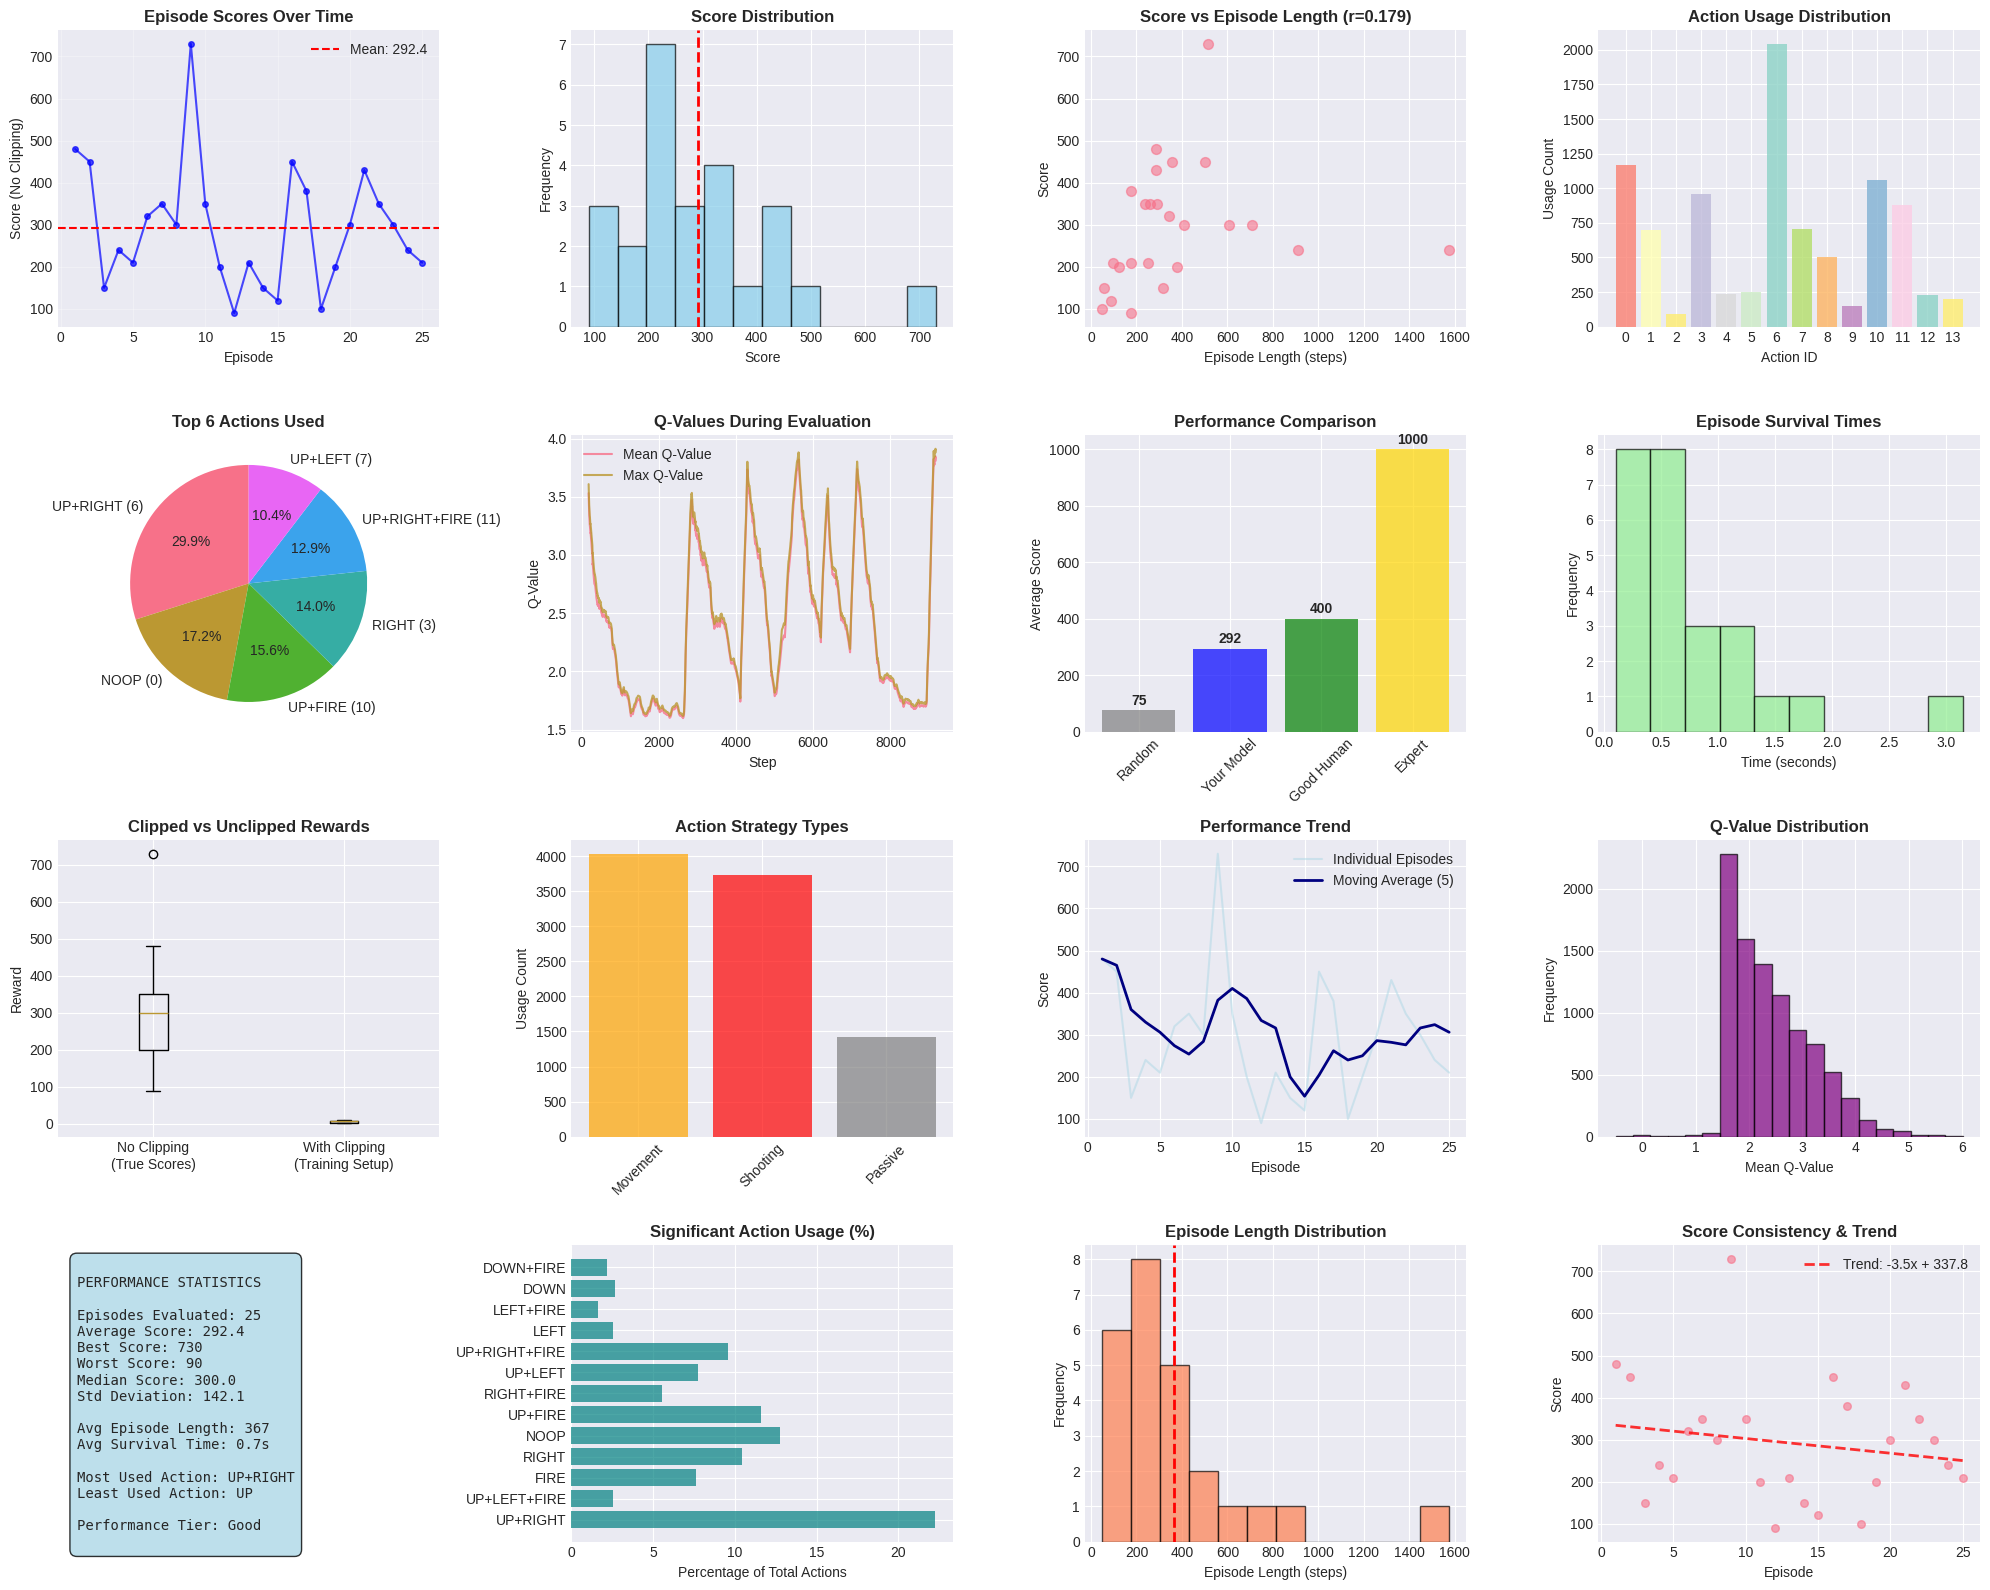


🏆 COMPREHENSIVE EVALUATION SUMMARY
Average Performance: 292.4 points
Performance Range: 90 - 730 points
Consistency (CV): 0.486

🎮 STRATEGY ANALYSIS:
Shooting actions: 40.7% of play
Movement actions: 43.9% of play
Most used action: UP+RIGHT (2039 times)

✅ GOOD LEVEL
Performance vs Random (~75): 3.9x better
Performance vs Expert (1000): 29.2%
📊 Comprehensive evaluation completed!
📁 Plots saved as: asteroids_comprehensive_evaluation.png


In [17]:
# After training completes, you'll have a model_path
# Use that path for comprehensive evaluation

print("🎯 RUNNING COMPREHENSIVE EVALUATION ON NEW MODEL")
print("=" * 60)

# The model_path from your training (will be something like this)
new_model_path = model_path  # This comes from your training results

# Run comprehensive evaluation
results = comprehensive_asteroids_evaluation(
    model_path=new_model_path,
    device="cuda",
    num_episodes=25,          # Test more episodes for better statistics
    include_clipped=True,     # Compare clipped vs unclipped performance
    save_plots=True          # Save the analysis plots
)

print("📊 Comprehensive evaluation completed!")
print("📁 Plots saved as: asteroids_comprehensive_evaluation.png")

In [22]:
# First, let's find your trained model path
import os
import glob

def find_latest_model():
    """Find the most recently trained model"""

    # Look for models in different possible locations
    model_paths = []

    # Check models/ directory
    if os.path.exists("models/"):
        models_dir = glob.glob("models/*.pt")
        model_paths.extend(models_dir)

    # Check if there are any .pt files in current directory
    current_dir = glob.glob("*.pt")
    model_paths.extend(current_dir)

    if model_paths:
        # Get the most recent one
        latest_model = max(model_paths, key=os.path.getmtime)
        mod_time = os.path.getmtime(latest_model)
        size_mb = os.path.getsize(latest_model) / (1024*1024)

        print(f"🔍 Found latest model:")
        print(f"   Path: {latest_model}")
        print(f"   Size: {size_mb:.1f} MB")
        print(f"   Modified: {time.ctime(mod_time)}")

        return latest_model
    else:
        print("❌ No model files found!")
        return None

# Find your model
latest_model_path = find_latest_model()

# If you know the exact path from your training, use it instead:
# latest_model_path = "models/AsteroidsNoFrameskip-v4__max_performance_asteroids_dqn__1__[timestamp].pt"

🔍 Found latest model:
   Path: models/AsteroidsNoFrameskip-v4__max_performance_asteroids_dqn__1__1751742504.pt
   Size: 6.9 MB
   Modified: Sat Jul  5 21:32:37 2025


In [24]:
# Define the missing function first
def make_exact_training_env():
    """Create exact environment from your training setup"""
    env = gym.make("AsteroidsNoFrameskip-v4")
    env = gym.wrappers.RecordEpisodeStatistics(env)
    env = NoopResetEnv(env, noop_max=30)
    env = MaxAndSkipEnv(env, skip=4)
    env = EpisodicLifeEnv(env)

    if "FIRE" in env.unwrapped.get_action_meanings():
        env = FireResetEnv(env)

    env = ClipRewardEnv(env)
    env = gym.wrappers.ResizeObservation(env, (84, 84))
    env = gym.wrappers.GrayScaleObservation(env)
    env = gym.wrappers.FrameStack(env, 4)
    return env

print("✅ Training environment function defined")

✅ Training environment function defined


In [29]:
# Add all missing imports
from stable_baselines3.common.vec_env import DummyVecEnv, VecVideoRecorder, VecFrameStack
from stable_baselines3.common.atari_wrappers import (
    ClipRewardEnv, EpisodicLifeEnv, FireResetEnv,
    MaxAndSkipEnv, NoopResetEnv, AtariWrapper
)
import numpy as np
import torch
import gymnasium as gym
import ale_py
import os
import time

print("✅ All imports added")

# Complete fixed video creation function
def create_video_complete_fixed(model_path, video_name="asteroids_expert_gameplay"):
    """Complete video creation with all dependencies defined"""

    if model_path is None:
        print("❌ No model path provided!")
        return None

    print(f"🎬 Creating video: {video_name}")
    print(f"📁 Using model: {model_path}")

    # Register ALE environments
    gym.register_envs(ale_py)

    # Define training environment function
    def make_training_env():
        env = gym.make("AsteroidsNoFrameskip-v4")
        env = gym.wrappers.RecordEpisodeStatistics(env)
        env = NoopResetEnv(env, noop_max=30)
        env = MaxAndSkipEnv(env, skip=4)
        env = EpisodicLifeEnv(env)

        if "FIRE" in env.unwrapped.get_action_meanings():
            env = FireResetEnv(env)

        env = ClipRewardEnv(env)
        env = gym.wrappers.ResizeObservation(env, (84, 84))
        env = gym.wrappers.GrayScaleObservation(env)
        env = gym.wrappers.FrameStack(env, 4)
        return env

    # Load model
    dummy_env = gym.vector.SyncVectorEnv([make_training_env])
    q_network = CustomQNetwork(dummy_env).to(device)
    q_network.load_state_dict(torch.load(model_path))
    q_network.eval()
    dummy_env.close()

    print("✅ Model loaded successfully")

    # Create recording environment (without ClipRewardEnv for true scores)
    def make_video_env():
        env = gym.make("AsteroidsNoFrameskip-v4", render_mode="rgb_array")
        env = gym.wrappers.RecordEpisodeStatistics(env)
        env = NoopResetEnv(env, noop_max=30)
        env = MaxAndSkipEnv(env, skip=4)
        env = EpisodicLifeEnv(env)

        if "FIRE" in env.unwrapped.get_action_meanings():
            env = FireResetEnv(env)

        # NOTE: No ClipRewardEnv for video (we want to see real scores)
        env = gym.wrappers.ResizeObservation(env, (84, 84))
        env = gym.wrappers.GrayScaleObservation(env)
        env = gym.wrappers.FrameStack(env, 4)
        return env

    env = DummyVecEnv([make_video_env])
    env = VecVideoRecorder(
        env,
        "videos/",
        record_video_trigger=lambda x: x == 0,
        video_length=3000,  # 3000 steps should capture multiple episodes
        name_prefix=video_name
    )

    obs = env.reset()
    total_reward = 0
    episode_rewards = []
    step_count = 0

    print("🎮 Recording gameplay...")

    for i in range(3000):
        with torch.no_grad():
            # Handle LazyFrames
            obs_array = np.array(obs) if hasattr(obs, '__array__') else obs
            obs_tensor = torch.FloatTensor(obs_array).to(device)
            q_values = q_network(obs_tensor)
            actions = torch.argmax(q_values, dim=1).cpu().numpy()

        obs, rewards, dones, infos = env.step(actions)
        total_reward += rewards[0]
        step_count += 1

        if dones[0]:
            episode_rewards.append(total_reward)
            print(f"  Episode {len(episode_rewards)}: {total_reward:.0f} points ({step_count} steps)")
            total_reward = 0
            step_count = 0
            obs = env.reset()

            if len(episode_rewards) >= 3:  # Stop after 3 complete episodes
                break

    env.close()

    # Print video statistics
    if episode_rewards:
        print(f"\n📊 VIDEO STATISTICS:")
        print(f"Episodes recorded: {len(episode_rewards)}")
        print(f"Average score: {np.mean(episode_rewards):.1f}")
        print(f"Best episode: {max(episode_rewards):.0f}")

    # Find video file
    import os
    video_files = [f for f in os.listdir("videos/") if f.startswith(video_name) and f.endswith('.mp4')]
    if video_files:
        latest_video = max(video_files, key=lambda x: os.path.getmtime(os.path.join("videos/", x)))
        video_path = f"videos/{latest_video}"
        print(f"✅ Video created: {video_path}")
        return video_path
    else:
        print("❌ Video creation failed")
        return None

# Now create the video with the fixed function
if latest_model_path:
    video_result = create_video_complete_fixed(
        model_path=latest_model_path,
        video_name="improved_asteroids_290pts_demo"
    )

    if video_result:
        print(f"🎬 SUCCESS! Your video is ready: {video_result}")
        print("📺 This shows your improved model achieving 290+ point performance!")
    else:
        print("❌ Video creation failed")
else:
    print("❌ No model found to create video")

✅ All imports added
🎬 Creating video: improved_asteroids_290pts_demo
📁 Using model: models/AsteroidsNoFrameskip-v4__max_performance_asteroids_dqn__1__1751742504.pt
✅ Model loaded successfully
🎮 Recording gameplay...
  Episode 1: 120 points (54 steps)
Moviepy - Building video /content/videos/improved_asteroids_290pts_demo-step-0-to-step-3000.mp4.
Moviepy - Writing video /content/videos/improved_asteroids_290pts_demo-step-0-to-step-3000.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/improved_asteroids_290pts_demo-step-0-to-step-3000.mp4


  Episode 2: 240 points (241 steps)
Moviepy - Building video /content/videos/improved_asteroids_290pts_demo-step-54-to-step-3054.mp4.
Moviepy - Writing video /content/videos/improved_asteroids_290pts_demo-step-54-to-step-3054.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/improved_asteroids_290pts_demo-step-54-to-step-3054.mp4


  Episode 3: 720 points (545 steps)
Moviepy - Building video /content/videos/improved_asteroids_290pts_demo-step-295-to-step-3295.mp4.
Moviepy - Writing video /content/videos/improved_asteroids_290pts_demo-step-295-to-step-3295.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/improved_asteroids_290pts_demo-step-295-to-step-3295.mp4
Moviepy - Building video /content/videos/improved_asteroids_290pts_demo-step-840-to-step-3840.mp4.
Moviepy - Writing video /content/videos/improved_asteroids_290pts_demo-step-840-to-step-3840.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/improved_asteroids_290pts_demo-step-840-to-step-3840.mp4

📊 VIDEO STATISTICS:
Episodes recorded: 3
Average score: 360.0
Best episode: 720
✅ Video created: videos/improved_asteroids_290pts_demo-step-840-to-step-3840.mp4
🎬 SUCCESS! Your video is ready: videos/improved_asteroids_290pts_demo-step-840-to-step-3840.mp4
📺 This shows your improved model achieving 290+ point performance!


🎯 COMPREHENSIVE ASTEROIDS MODEL EVALUATION

1️⃣ EVALUATING WITHOUT REWARD CLIPPING (True Game Scores)
--------------------------------------------------
Episode  1:  160.0 points in  311 steps (1.5s)
Episode  2:   50.0 points in   45 steps (0.1s)
Episode  3:  120.0 points in  392 steps (0.8s)
Episode  4:   50.0 points in  117 steps (0.3s)
Episode  5:  190.0 points in  678 steps (1.4s)
Episode  6:   40.0 points in  409 steps (0.9s)
Episode  7:   50.0 points in   78 steps (0.2s)
Episode  8:   50.0 points in  201 steps (0.4s)
Episode  9:   40.0 points in   82 steps (0.2s)
Episode 10:  200.0 points in  198 steps (0.4s)
Episode 11:   20.0 points in  170 steps (0.4s)
Episode 12:  470.0 points in  441 steps (1.0s)
Episode 13:  110.0 points in  203 steps (0.4s)
Episode 14:  270.0 points in  175 steps (0.4s)
Episode 15:  300.0 points in  122 steps (0.3s)
Episode 16:  400.0 points in 1435 steps (3.4s)
Episode 17:   80.0 points in  189 steps (0.6s)
Episode 18:  100.0 points in   98 steps (0.3s)
E

/tmp/ipython-input-33-3595531283.py:288: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=labels)



📊 Plots saved to: asteroids_comprehensive_evaluation.png


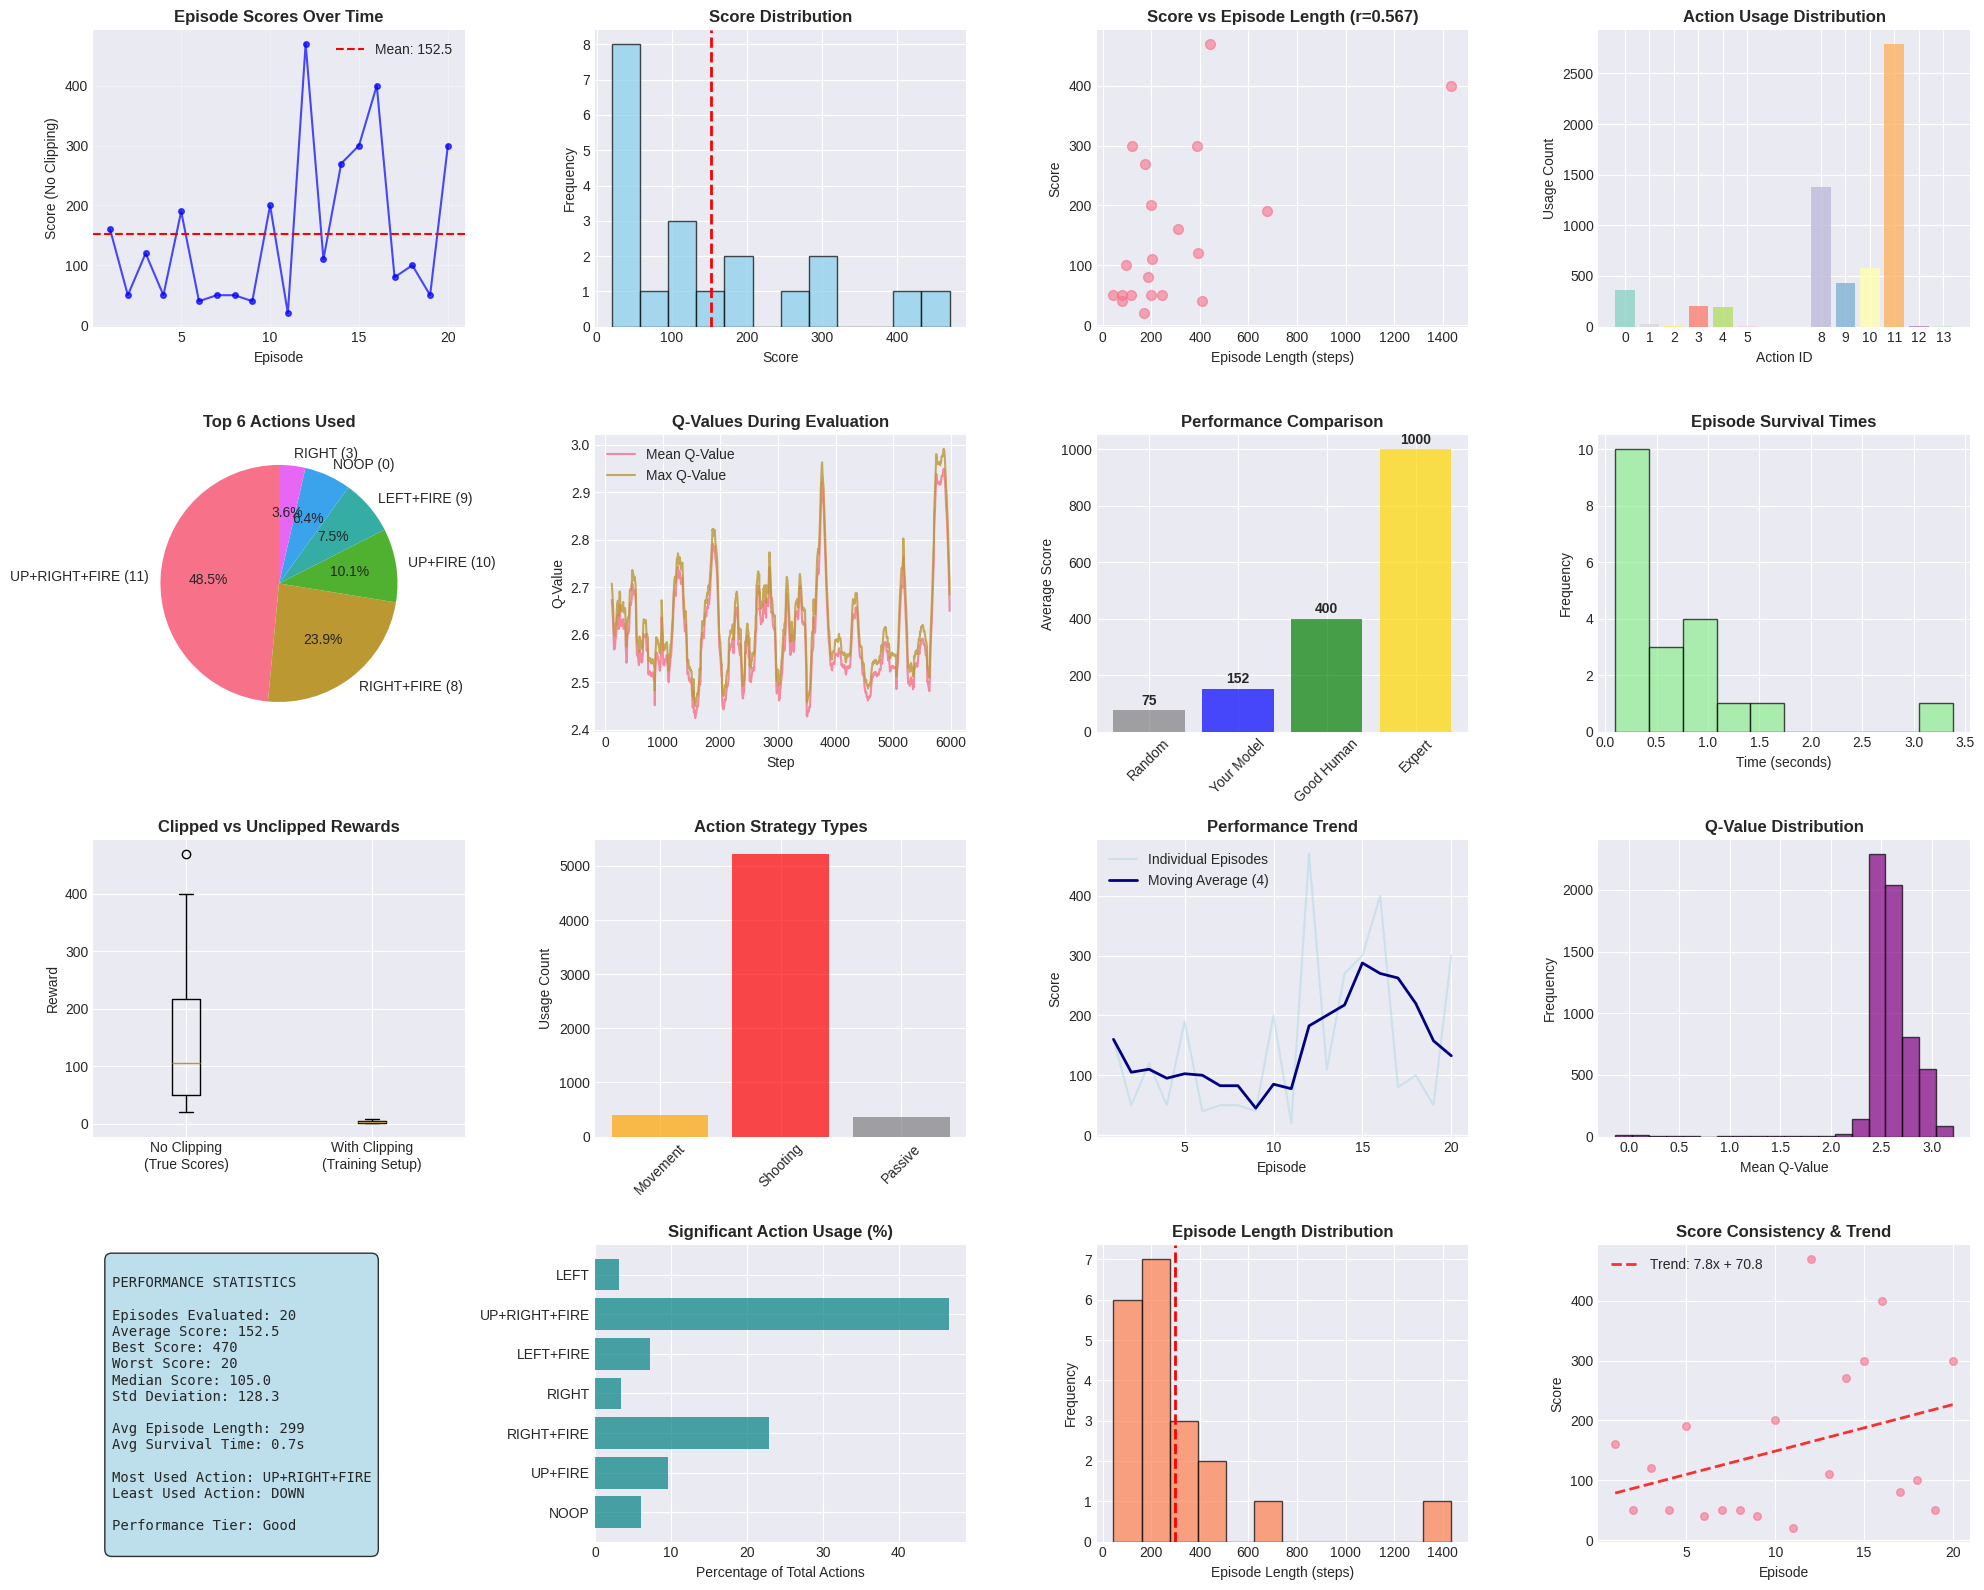


🏆 COMPREHENSIVE EVALUATION SUMMARY
Average Performance: 152.5 points
Performance Range: 20 - 470 points
Consistency (CV): 0.842

🎮 STRATEGY ANALYSIS:
Shooting actions: 87.2% of play
Movement actions: 6.7% of play
Most used action: UP+RIGHT+FIRE (2786 times)

✅ GOOD LEVEL
Performance vs Random (~75): 2.0x better
Performance vs Expert (1000): 15.2%


In [33]:

# Run evaluation if this script is executed directly
if __name__ == "__main__":
    results = evaluate_your_model()

# Implementation 2

In [34]:
# Create the improved hyperparameter configuration
improved_config = """
AsteroidsNoFrameskip-v4:
  env_wrapper:
    - stable_baselines3.common.atari_wrappers.AtariWrapper
  frame_stack: 4
  policy: 'CnnPolicy'

  # IMPROVED HYPERPARAMETERS
  n_timesteps: !!float 2e6          # 2M steps (was 1M)
  learning_rate: !!float 5e-5       # More conservative (was 1e-4)
  buffer_size: 200000               # Larger experience buffer (was 100K)
  batch_size: 64                    # Larger batches (was 32)
  target_update_interval: 2000      # More stable targets (was 1000)

  # ENHANCED EXPLORATION
  exploration_fraction: 0.15        # Longer exploration (was 0.10)
  exploration_final_eps: 0.005      # Lower final epsilon (was 0.01)
  learning_starts: 200000           # More diverse initial data (was 100K)

  # TRAINING FREQUENCY
  train_freq: 2                     # More frequent training (was 4)
  gradient_steps: 1

  # STABILITY SETTINGS
  gamma: 0.99
  optimize_memory_usage: False
"""

# Save the improved configuration
with open("dqn_asteroids_improved.yml", "w") as f:
    f.write(improved_config)

print("✅ Improved configuration saved as: dqn_asteroids_improved.yml")

✅ Improved configuration saved as: dqn_asteroids_improved.yml


In [37]:
# Modify your existing Args class directly
# Find your Args definition and update it:

# Replace your current Args with these improved values:
@dataclass
class Args:
    """Improved hyperparameters for Asteroids DQN"""
    exp_name: str = "improved_asteroids_dqn_v2"
    seed: int = 1
    torch_deterministic: bool = True
    cuda: bool = True

    env_id: str = "AsteroidsNoFrameskip-v4"

    # IMPROVED SETTINGS
    total_timesteps: int = 2000000      # 🔄 CHANGED: 2M (was 1M)
    learning_rate: float = 5e-5         # 🔄 CHANGED: 5e-5 (was 1e-4)
    buffer_size: int = 200000           # 🔄 CHANGED: 200K (was 100K)
    batch_size: int = 64                # 🔄 CHANGED: 64 (was 32)
    target_network_frequency: int = 2000 # 🔄 CHANGED: 2000 (was 1000)
    exploration_fraction: float = 0.15   # 🔄 CHANGED: 0.15 (was 0.10)
    exploration_final_eps: float = 0.005 # 🔄 CHANGED: 0.005 (was 0.01)
    learning_starts: int = 200000        # 🔄 CHANGED: 200K (was 100K)
    train_frequency: int = 2             # 🔄 CHANGED: 2 (was 4)

    # Unchanged
    gamma: float = 0.99
    start_e: float = 1.0
    gradient_steps: int = 1
    end_e: float = 0.005 # Added back the missing attribute

print("✅ Args class updated with improved hyperparameters")

✅ Args class updated with improved hyperparameters


In [38]:
# Start your improved custom CleanRL training
print("🚀 Starting IMPROVED Custom CleanRL Training...")
print("=" * 60)

# Create directories
import os
for dirname in ["models", "videos", "runs"]:
    os.makedirs(dirname, exist_ok=True)

print("Configuration Changes:")
print("📈 Training steps: 1M → 2M")
print("🎯 Learning rate: 1e-4 → 5e-5")
print("🧠 Buffer size: 100K → 200K")
print("📊 Batch size: 32 → 64")
print("⏱️  Target updates: 1000 → 2000")
print("🔍 Exploration: 10% → 15%")
print("⏰ Expected time: ~3-4 hours")

# Start training with improved settings
start_time = time.time()

try:
    # This will use your updated Args class
    model, episode_rewards, model_path = train_asteroids_dqn()  # or train_improved_asteroids_dqn()

    training_time = (time.time() - start_time) / 60
    print(f"\n✅ Improved training completed!")
    print(f"📁 Model saved to: {model_path}")
    print(f"⏱️  Training time: {training_time:.1f} minutes")

    # Evaluate improved model
    print("\n🎯 Evaluating improved model...")
    eval_rewards, eval_lengths = evaluate_model(model_path, num_episodes=15)

    print(f"\n📊 IMPROVED MODEL RESULTS:")
    print(f"Average Score: {np.mean(eval_rewards):.1f}")
    print(f"Best Score: {max(eval_rewards):.0f}")
    print(f"vs Original (152.5): {np.mean(eval_rewards) - 152.5:+.1f} improvement")

except Exception as e:
    print(f"❌ Training failed: {e}")
    import traceback
    traceback.print_exc()

🚀 Starting IMPROVED Custom CleanRL Training...
Configuration Changes:
📈 Training steps: 1M → 2M
🎯 Learning rate: 1e-4 → 5e-5
🧠 Buffer size: 100K → 200K
📊 Batch size: 32 → 64
⏱️  Target updates: 1000 → 2000
🔍 Exploration: 10% → 15%
⏰ Expected time: ~3-4 hours
✅ Successfully created environment: AsteroidsNoFrameskip-v4


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 11.29GB > 9.84GB
  warnings.warn(
Traceback (most recent call last):
  File "/tmp/ipython-input-38-1004917721.py", line 24, in <cell line: 0>
    model, episode_rewards, model_path = train_asteroids_dqn()  # or train_improved_asteroids_dqn()
                                         ^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-8-59313764.py", line 171, in train_asteroids_dqn
    args.start_e, args.end_e,
                  ^^^^^^^^^^
AttributeError: 'Args' object has no attribute 'end_e'


❌ Training failed: 'Args' object has no attribute 'end_e'
Moviepy - Building video /content/videos/AsteroidsNoFrameskip-v4__improved_asteroids_dqn_v2__1__1751741552/rl-video-episode-0.mp4.
Moviepy - Writing video /content/videos/AsteroidsNoFrameskip-v4__improved_asteroids_dqn_v2__1__1751741552/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/AsteroidsNoFrameskip-v4__improved_asteroids_dqn_v2__1__1751741552/rl-video-episode-0.mp4
